<a href="https://colab.research.google.com/github/aidarBARMEN/IntroToML/blob/main/HeartDeseasePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of the project is to identify patterns related to the risk of heart disease and build a model that predicts the likelihood of its presence. The model's output is the probability (in percent) of having heart disease. This will help doctors assess the risk and make decisions about the need for examination.

# Imports


In [2]:
import kagglehub

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score, f1_score, log_loss, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

sns.set_theme()

# Dataset


In [3]:
path: str = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
heart_csv_path: str = path + "/heart.csv"

heart_df = pd.read_csv(heart_csv_path)

# Functions

In [4]:
# Interquartile range (IQR)
def compute_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f"{col}:")
    print(f"  - Outliers boundaries: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  - Number of outliers: {len(outliers)}")
    print(f"  - Outliers rate: {len(outliers) / len(data):.2%}")
    print("-" * 50)

# Distribution Plot and Boxplot (for numerical features)

def plot_distribution_and_boxplot(data, col):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

  sns.histplot(data = data, x=col, kde=True, ax=axes[0], hue='HeartDisease')
  axes[0].set_title(f'Distribution {col}')

  sns.boxplot(data=data, x='HeartDisease', y=col, ax=axes[1])
  axes[1].set_title(f'Boxplot {col}')

  plt.tight_layout()
  plt.show()

# Function for Evaluating Model Performance with Different Scaling Methods
def evaluate_scaling_performance(scalers, model, X_train, X_test, y_train, y_test):
    results = {}

    for scaler_name, scaler in scalers.items():

        if scaler is not None:
            X_train_scaled = scaler.fit_transform(X_train)  # Training the scaler and transforming the data
            X_test_scaled = scaler.transform(X_test)       # Transforming test data
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test

        # Model training
        model.fit(X_train_scaled, y_train)

        # Model evaluation
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)

        report = classification_report(y_test, y_pred)  #

        # Saving the result
        results[scaler_name] = report

    return results

# Preliminary analysis

The project uses the *Heart Failure Prediction* Dataset, containing **918** entries and **12** features aimed at predicting the presence of cardiovascular disease `HeartDisease`. All features are clinical and were collected from various sources (Cleveland, Hungarian, Long Beach VA, etc.), merged into a single consistent dataset.  

---

**Features:**  
- `Age`: patient's age (in years)  
- `Sex`: gender (M — male, F — female)  
- `ChestPainType`: chest pain type (TA, ATA, NAP, ASY)  
- `RestingBP`: resting blood pressure (mm Hg)  
- `Cholesterol`: cholesterol level (mg/dL)  
- `FastingBS`: fasting blood sugar (0 or 1, where 1 — >120 mg/dL)  
- `RestingECG`: resting ECG results (Normal, ST, LVH)  
- `MaxHR`: maximum achieved heart rate  
- `ExerciseAngina`: exercise-induced angina (Y/N)  
- `Oldpeak`: ST segment depression (numeric value)  
- `ST_Slope`: slope of the ST segment during peak exercise (Up, Flat, Down)  

---

**Target variable:**  
- `HeartDisease`: target variable (0 — no disease, 1 — present)  

In [5]:
heart_df = pd.read_csv(heart_csv_path)
print(f"data frame shape = {heart_df.shape}")
heart_df.head()

data frame shape = (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


First, let's check for missing values in the dataset.  
```python
heart_df.isnull().sum()
```

The good news is that the dataset was preprocessed and contains no empty cells, which simplifies our work.

In [6]:
heart_df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [7]:
print(heart_df.duplicated().sum())

0


Also, the dataset does not contain duplicates.

# Dividing features into groups

In [8]:
numerical_cols = ['Age','RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
binary_cols = ['Sex','FastingBS', 'ExerciseAngina']
categorical_cols = ['ChestPainType', 'RestingECG', 'ST_Slope']

target = 'HeartDisease'

As a result, we have 5 numerical features, 3 binary and 3 categorical

# Analysis

This block is devoted to the analysis of features in relation to the target variable.

## Age and Sex

Let's start our analysis with the `Age` feature. We're interested in the relationship between age and `HeartDisease`. Note that `1` indicates presence of disease, while `0` indicates absence. Let's examine the proportions of healthy and diseased individuals across different ages, with separate analysis for men and women.

---

**Visualization:**
The plots show age distributions for men and women, segmented by heart disease status (HeartDisease), normalized by proportion.

**Men (left plot):**
- Below 45 years: healthy individuals outnumber those with heart disease
- After 50 years: sharp increase in heart disease cases, with diseased individuals surpassing healthy ones
- At 60 years: number of diseased individuals doubles the healthy count

**Women (right plot):**
- Below 45 years: healthy individuals outnumber diseased ones by 3:1 ratio
- At 60 years: disease prevalence reaches parity with healthy cases

Key observations from the visualization:
1. Men show significantly higher incidence of heart disease
2. Peak proportion of healthy individuals occurs around age 40
3. The 50-55 age range represents a critical threshold where disease prevalence matches healthy cases, suggesting accumulated risk factors (elevated cholesterol, chronic stress) manifest as cardiac conditions
4. Beyond 60 years: diseased individuals consistently outnumber healthy ones, peaking at 60-65 years - consistent with medical data on age-related cardiovascular risks

---

Key conclusions:
- The 50-55 age range represents a critical period requiring enhanced medical monitoring to identify and mitigate risk factors

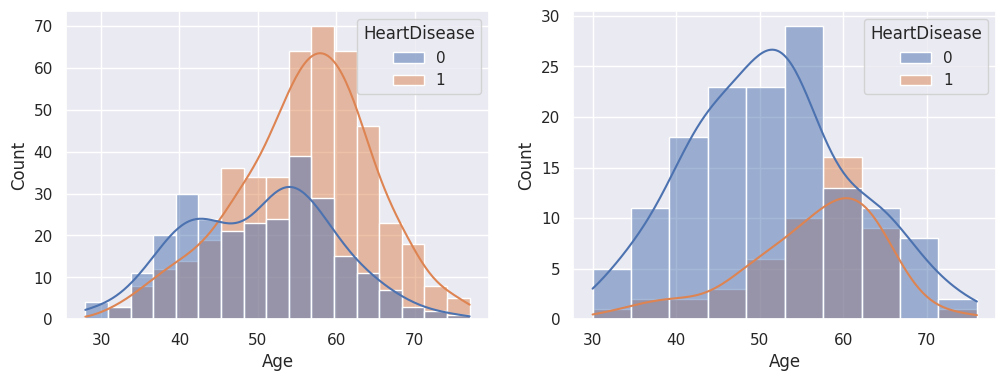

In [9]:
males = heart_df[heart_df['Sex'] == 'M']
females = heart_df[heart_df['Sex'] == 'F']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(males, x='Age', hue='HeartDisease', ax=axes[0], kde=True)
sns.histplot(females, x='Age', hue='HeartDisease', ax=axes[1], kde=True)

axes[0].set_title = "Males"
axes[1].set_title = "Females"


We're also interested in calculating disease probability relative to age. To compute heart problem probability, we need to divide the total number of diseased cases by the sum of diseased and healthy cases:

$$
P(disease) = \frac{N_{disease}}{N_{disease}+N_{healthy}}
$$

The dataset contains 918 records total, and for more reliable results it's better to split the dataset into age groups. First we find minimum and maximum ages:
```py
min_age = heart_df['Age'].min()  # 28
max_age = heart_df['Age'].max()  # 77
```
We'll use a step of `step=12` years (somewhat arbitrary number). We find group boundaries and use `pd.cut()` to split data into required groups:

```py
step = 12
age_bins = [i for i in range(min_age, max_age, step)]
age_bin_names = [f"{i}-{i+step}" for i in age_bins[:-1]]

heart_df['AgeGroup'] = pd.cut(heart_df["Age"], bins=age_bins, labels=age_bin_names)

```

<Axes: xlabel='AgeGroup', ylabel='HeartDisease'>

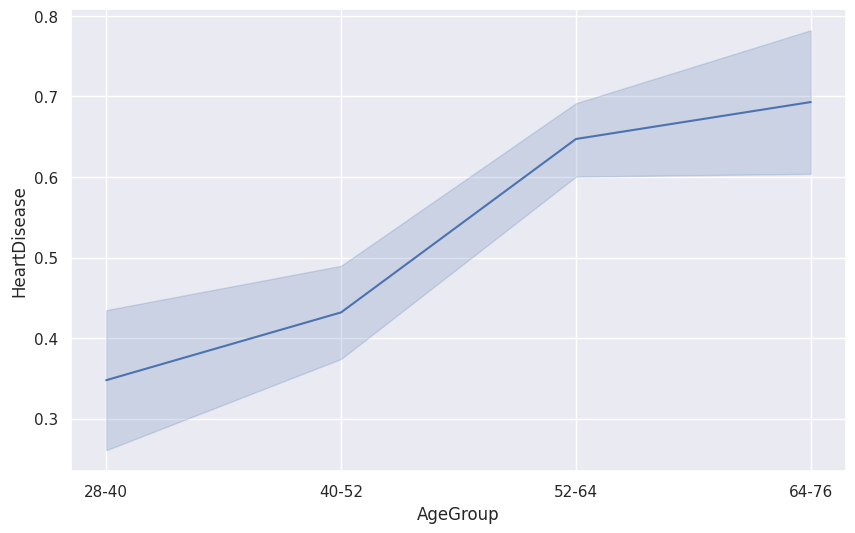

In [10]:
min_age = heart_df['Age'].min()  # 28
max_age = heart_df['Age'].max()  # 77

step = 12
age_bins = [i for i in range(min_age, max_age, step)]
age_bin_names = [f"{i}-{i+step}" for i in age_bins[:-1]]


heart_df['AgeGroup'] = pd.cut(heart_df["Age"], bins=age_bins, labels=age_bin_names)

plt.figure(figsize=(10, 6))
sns.lineplot(
    heart_df, x='AgeGroup', y='HeartDisease', errorbar=("ci", 95),
)

In [11]:
heart_df.drop(columns=['AgeGroup'], inplace=True)

## ChestPainType

Next parameter is `ChestPainType`. Below you can see a histogram created using `seaborn.histplot` to visualize the distribution of `ChestPainType` feature in relation to heart disease presence `HeartDisease`.

---

Looking at the graph, we can clearly observe that `ASY` accounts for the largest proportion in positive `HeartDisease` cases among all pain types.  
`ASY` stands for Asymptomatic, meaning patients don't experience any symptoms. This leads us to conclude that for most patients with pathology, the disease progresses without `ChestPainType` symptoms.  
Some people mistakenly believe that if they don't have chest pain, their heart is fine. From this graph we can conclude that absence of chest pain doesn't guarantee absence of pathology.

We can also note that `ATA` pain type is associated with lower risk of heart disease. This might suggest that atypical angina is more often related to non-cardiac causes (such as muscular, digestive or psychosomatic issues).

<Axes: xlabel='ChestPainType', ylabel='Proportion'>

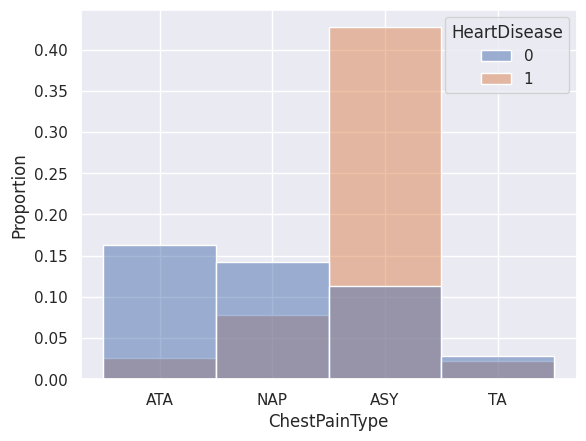

In [12]:
sns.histplot(heart_df, x="ChestPainType", hue="HeartDisease", stat="proportion")

## RestingBP

Now let's examine `RestingBP`. First we need to remove artifacts - the dataset contains records with `RestingBP` equal to zero. These are clinically impossible values for a living person, so we'll filter only relevant data.  
We'll filter `RestingBP` using a threshold of 60 mmHg (the lower limit for a living adult, values below are extremely unlikely).
```py
heart_df_without_zero_resting_bp = heart_df[heart_df['RestingBP'] > 60]
```

---

Looking at the plot, we can make two key observations:
1. Both group distributions are close to normal, with very similar centers and distribution patterns. This is explained by the fact that most people are concentrated in the center of the distribution. Logically, the distribution center for people with heart disease is approximately the same as the overall `RestingBP` center.
2. The plot for the `HeartDisease` group is slightly shifted right - showing positive skewness (right-sided slope). This indicates that people with higher blood pressure more frequently have heart disease. This conclusion is supported by medical data. The shift becomes noticeable at `RestingBP=125`, which can be considered a critical value. These findings align with real-world data. According to WHO guidelines, blood pressure is considered elevated starting from 120 mmHg.

<Axes: xlabel='RestingBP', ylabel='Proportion'>

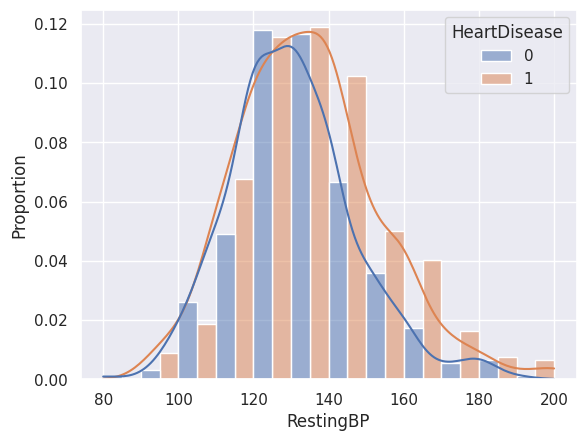

In [13]:
heart_df_without_zero_resting_bp = heart_df[heart_df['RestingBP'] > 30]

sns.histplot(heart_df_without_zero_resting_bp, x="RestingBP", hue="HeartDisease", stat="proportion", multiple='dodge', bins=12, kde=True)

## Cholesterol

Just like with `RestingBP`, the `Cholesterol` column also contains zero values — a medically impossible occurrence. The minimum acceptable level is considered to be 2 mmol/L. We do the same as with `RestingBP`: filter and plot the data.  
Here we used `violinplot`.  
A violin plot combines features of a boxplot and KDE (kernel density estimate), showing the data distribution along with its density.

---

The plot shows the expected result. For `HeartDisease=1`, the distribution median is shifted upwards, with its center at 245, while for `HeartDisease=0`, the median is at 230. People with heart disease (HeartDisease=1) often have high cholesterol and excess weight, which may explain the higher median values. Those without heart disease (HeartDisease=0) usually show lower values.

<Axes: xlabel='HeartDisease', ylabel='Cholesterol'>

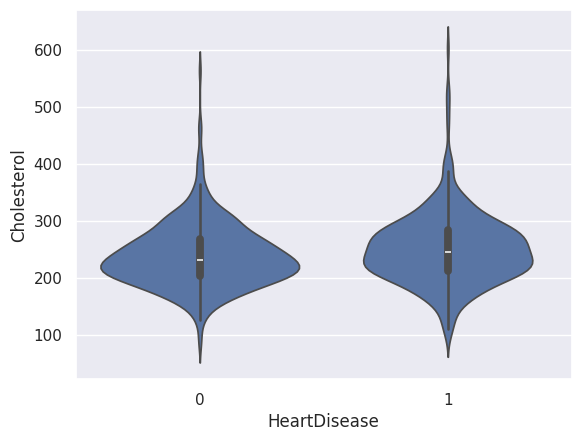

In [14]:
heart_df_without_zero_cholesterol = heart_df[heart_df["Cholesterol"] > 2]
sns.violinplot(heart_df_without_zero_cholesterol, x="HeartDisease", y="Cholesterol")


## FastingBS

`FastingBS` is a binary value, where `1` indicates elevated fasting blood sugar, and `0` indicates a normal level.  
The following plot shows the average `HeartDisease` value for `FastingBS=0` and `FastingBS=1`.  
Since `HeartDisease` is also binary, the average can be interpreted as the probability of having the disease.

---

For `FastingBS=0`, the average value was `0.475`, and for `FastingBS=1`, it was `0.785`. This means that the probability of having heart disease is significantly higher in people with elevated fasting blood sugar (`FastingBS=1`) compared to those with normal levels (`FastingBS=0`).

---

This code calculates the Pearson correlation between `FastingBS` and `HeartDisease`:
```python
fasting_bs_corr = heart_df["FastingBS"].corr(heart_df["HeartDisease"])
```

As a result, the correlation is `0.27` (a weak positive relationship).

Correlation = 0.27


<Axes: xlabel='FastingBS', ylabel='HeartDisease'>

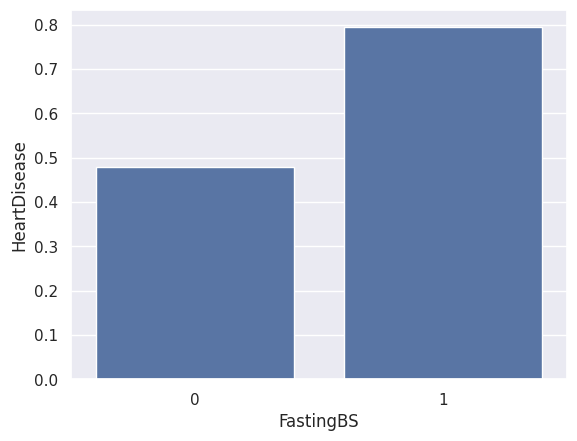

In [15]:
fasting_bs_agg_data = heart_df.groupby('FastingBS')['HeartDisease'].mean().reset_index()
fasting_bs_corr = heart_df["FastingBS"].corr(heart_df["HeartDisease"])

print(f"Correlation = {fasting_bs_corr:.2f}")

sns.barplot(data=fasting_bs_agg_data, x='FastingBS', y='HeartDisease')

## RestingECG

RestingECG is the result of a resting ECG test. It indicates whether there are any abnormalities in heart function:
- Normal — normal ECG
- ST — ST segment abnormalities (possible ischemia/strain)
- LVH — signs of left ventricular hypertrophy

---

The plot shows a weak association between the ST category and the presence of heart disease.  
The ST category is often associated with ischemic changes — impaired blood flow to the heart muscle. This may be a sign of angina or an early stage of coronary artery disease.

<Axes: xlabel='RestingECG', ylabel='count'>

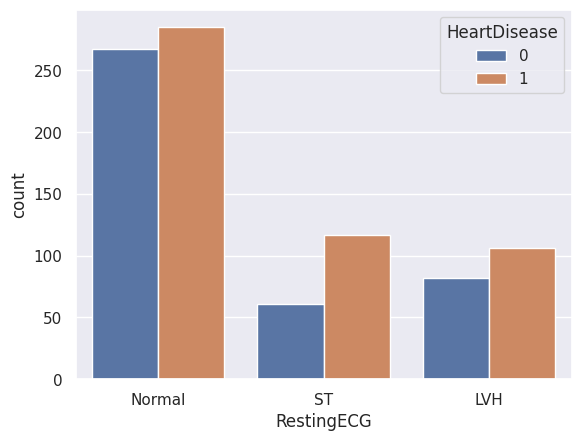

In [16]:
sns.countplot(heart_df, x='RestingECG', hue='HeartDisease')

## MaxHR

MaxHR is the maximum heart rate.  
In the plot, we can see that the median `MaxHR` for people with heart disease is 126 bpm, while for healthy individuals it is 150 bpm.  
This suggests that healthy individuals may have better-trained hearts, allowing them to reach higher maximum heart rate (MaxHR) values compared to those with heart disease.

<Axes: xlabel='MaxHR'>

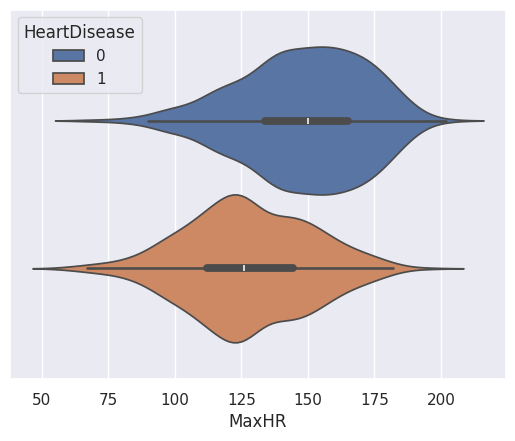

In [17]:
sns.violinplot(heart_df, x="MaxHR", hue="HeartDisease", fill=True)

## ExerciseAngina

ExerciseAngina is a variable indicating whether the patient experienced angina during physical exertion. Angina is chest pain or discomfort caused by insufficient blood flow to the heart.
- Y (Yes) — the patient had angina during exercise.
- N (No) — the patient did not have angina during exercise.

---

This code groups the data by `ExerciseAngina` and calculates the average `HeartDisease` value for each group ("Y" and "N"):
```py
exercise_angina_agg_data = heart_df.groupby('ExerciseAngina')['HeartDisease'].mean().reset_index()
```
Then, it calculates the correlation and builds a bar chart showing the average `HeartDisease` value for "Y" and "N" groups in `ExerciseAngina`.

---

The plot demonstrates a strong association between exercise-induced angina (`ExerciseAngina`) and the presence of heart disease. Patients with `ExerciseAngina=Y` have about an 85% chance of heart disease — 2.5 times higher than the group without symptoms (`N`). A moderate correlation (0.49) confirms the **high** importance of this feature for predictive models.

Correlation = 0.49


<Axes: xlabel='ExerciseAngina', ylabel='HeartDisease'>

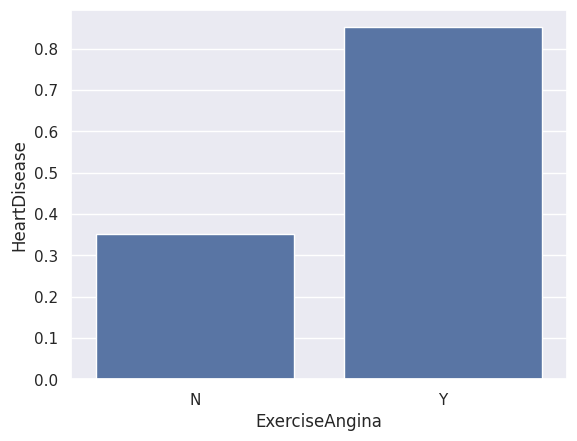

In [18]:
exercise_angina_agg_data = heart_df.groupby('ExerciseAngina')['HeartDisease'].mean().reset_index()
exercise_angina_encoded = heart_df['ExerciseAngina'].map({"Y": 1, "N": 0})
exercise_angina_corr = exercise_angina_encoded.corr(heart_df["HeartDisease"])
print(f"Correlation = {exercise_angina_corr:.2f}")

sns.barplot(data=exercise_angina_agg_data, x='ExerciseAngina', y='HeartDisease')


## ST_Slope

ST_Slope is a variable that describes the slope of the ST segment on an electrocardiogram (ECG) during physical exercise. The ST segment slope is important for diagnosing heart diseases, as changes in the slope may indicate ischemia.

`Up` — upward slope of the ST segment (may be normal, especially during recovery after exercise)  
`Flat` — flat ST segment (may indicate signs of ischemia)  
`Down` — downward slope of the ST segment (may suggest ischemia or oxygen deficiency in the heart)

---

In the code, we do the same as in the previous steps.

---

From the plot, we can see that `ST_Slope` is strongly associated with heart disease. The `Flat` and `Down` categories are linked with a higher probability of heart disease (~80%), while the normal `Up` category is only ~20%. This aligns with clinical knowledge, as flat and downward slopes of the ST segment often indicate ischemic changes in the myocardium — meaning insufficient blood supply to the heart during stress. These changes are typical in patients with coronary artery disease. In contrast, the upward slope (`Up`) is commonly seen in healthy individuals and is considered a physiological response to exercise. Thus, the high frequency of heart disease in `Flat` and `Down` supports clinical observations.

The correlation coefficient (if `Down`, `Flat`, and `Up` are ordered ascendingly) would be positive. However, it's important to note that such ordering is not medically accurate. Mapping categories like `Down`, `Flat`, and `Up` to numeric values (e.g., -1, 0, 1) is a technical simplification for computing correlation, but it does not reflect a real medical or physiological scale. In medicine, these values represent distinct types of ST segment deviations and cannot be interpreted as a linear risk scale.

Correlation = -0.56


<Axes: xlabel='ST_Slope', ylabel='HeartDisease'>

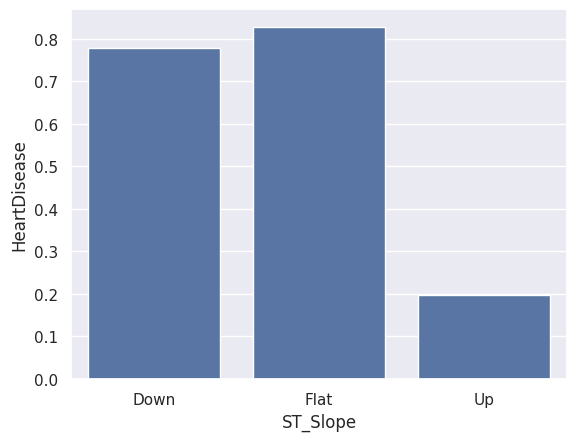

In [19]:
st_slope_agg_data = heart_df.groupby('ST_Slope')['HeartDisease'].mean().reset_index()
st_slope_encoded = heart_df['ST_Slope'].map({"Up": 1, "Flat": 0, "Down": -1})
st_slope_corr = st_slope_encoded.corr(heart_df["HeartDisease"])

print(f"Correlation = {st_slope_corr:.2f}")

sns.barplot(data=st_slope_agg_data, x='ST_Slope', y='HeartDisease')


# Data processing

## OHE (One Hot Encoding)

To begin with, all string values need to be converted to numeric ones.

---

Sex is a categorical feature that takes the values `M` (Male) or `F` (Female).
The following code converts all `M` values to 1 and all `F` values to 0:
```py
heart_df["Sex"] = [1 if i == "M" else 0 for i in heart_df["Sex"]]
```

---

`ChestPainType` is a categorical feature describing the type of chest pain. It usually includes the following values:

- `ATA` — Atypical Angina  
- `NAP` — Non-Anginal Pain  
- `ASY` — Asymptomatic  
- `TA` — Typical Angina

These are **nominal** categories (no inherent order), so **One-Hot Encoding (OHE)** is the best choice.

The following code applies one-hot encoding to the `ChestPainType` column: it creates new columns `ChestPainType_TA`, `ChestPainType_ATA`, `ChestPainType_NAP`, and `ChestPainType_ASY` with values `1` or `0` depending on the original value, and removes the original column:

```python
pain_types = ['TA', 'ATA', 'NAP', 'ASY']
for pain_type in pain_types:
    chest_pain_type_column_name = "ChestPainType_" + pain_type
    heart_df[chest_pain_type_column_name] = [1 if i == pain_type else 0 for i in heart_df["ChestPainType"]]

heart_df.drop(columns=["ChestPainType"], inplace=True)
```
---

`RestingECG` (resting electrocardiogram results) is a categorical feature with 3 possible values:

- `Normal`: normal ECG results.   
- `ST`: abnormality in the ST-T segment (e.g. T wave inversion and/or ST elevation or depression over 0.05 mV)  
- `LVH`: probable or definite left ventricular hypertrophy diagnosed using Estes criteria.

The values `Normal`, `ST`, and `LVH` represent categorical states that don’t have a clear order (i.e., we can’t say one is “more important” or “more severe” than another in the context of disease classification).

So the best approach for this feature is one-hot encoding.

The following code does the same as in the `ChestPainType` step:
```python
ecg_types = ['Normal', 'ST', 'LVH']
for ecg_type in ecg_types:
    ecg_type_column_name = "RestingECG_" + ecg_type
    heart_df[ecg_type_column_name] = [1 if i == ecg_type else 0 for i in heart_df["RestingECG"]]

heart_df.drop(columns=["RestingECG"], inplace=True)
```

---

`ExerciseAngina` is a binary feature that indicates whether or not chest pain occurred during physical exertion. The values `Y` (Yes) and `N` (No) are converted to numeric format, where `Y` = 1 (indicating angina symptoms) and `N` = 0 (no symptoms).

The following code does the same as in the `Sex` step:
```python
heart_df["ExerciseAngina"] = [1 if i == "Y" else 0 for i in heart_df["ExerciseAngina"]]
```

---

`ST_Slope` is a categorical feature describing the slope of the `ST` segment on an electrocardiogram (ECG). It can have three values: `Up`, `Flat`, and `Down`.
At first glance, these values may seem ordinal, but in reality, they are nominal because there is no clear order in terms of what is “worse” or “better.” Sometimes `Up` can indicate hypertension, but it may also be normal for athletes. `Flat` may also suggest a normal state or instability. Also, the `Up` category does not indicate how steep the slope is—there’s no amplitude or degree of elevation.

So it’s best to use one-hot encoding here.
The following code applies **OHE** to the `ST_Slope` feature and then removes the original column:
```python
st_slope_types = ["Up", "Flat", "Down"]
for slope_type in st_slope_types:
    st_slope_type_column_name = "ST_Slope_" + slope_type
    heart_df[st_slope_type_column_name] = [1 if i == slope_type else 0 for i in heart_df["ST_Slope"]]
heart_df.drop(columns=["ST_Slope"], inplace=True)
```

In [20]:
# Sex
heart_df["Sex"] = [1 if i == "M" else 0 for i in heart_df["Sex"]]

# ChestPainType
pain_types = ['ATA', 'NAP', 'ASY']
for pain_type in pain_types:
    chest_pain_type_column_name = "ChestPainType_" + pain_type
    heart_df[chest_pain_type_column_name] = [1 if i == pain_type else 0 for i in heart_df["ChestPainType"]]

heart_df.drop(columns=["ChestPainType"], inplace=True)

# RestingECG
ecg_types = ['ST', 'LVH']
for ecg_type in ecg_types:
    ecg_type_column_name = "RestingECG_" + ecg_type
    heart_df[ecg_type_column_name] = [1 if i == ecg_type else 0 for i in heart_df["RestingECG"]]

heart_df.drop(columns=["RestingECG"], inplace=True)

# ExerciseAngina
heart_df["ExerciseAngina"] = [1 if i == "Y" else 0 for i in heart_df["ExerciseAngina"]]

# ST_Slope
st_slope_types = ["Flat", "Down"]
for slope_type in st_slope_types:
    st_slope_type_column_name = "ST_Slope_" + slope_type
    heart_df[st_slope_type_column_name] = [1 if i == slope_type else 0 for i in heart_df["ST_Slope"]]
heart_df.drop(columns=["ST_Slope"], inplace=True)

heart_df.head()



,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_ASY,RestingECG_ST,RestingECG_LVH,ST_Slope_Flat,ST_Slope_Down
0,40,1,140,289,0,172,0,0.0,0,1,0,0,0,0,0,0
1,49,0,160,180,0,156,0,1.0,1,0,1,0,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,1,0,0,1,0,0,0
3,48,0,138,214,0,108,1,1.5,1,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,1,0,0,0,0,0


## Scaling

In [21]:
X = heart_df.drop('HeartDisease', axis=1)
y = heart_df['HeartDisease']

# Splitting into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()

# Defining scaling methods
scalers = {
    "No Scaling": None,
    "StandardScaler": StandardScaler(),  # Standardization (mean=0, variance=1)
    "MinMaxScaler": MinMaxScaler(),      # Scaling to range [0,1]
    "RobustScaler": RobustScaler()       # Robust scaling (resistant to outliers)
}

# Evaluating performance for each scaling method
performance_results = evaluate_scaling_performance(scalers, model, X_train, X_test, y_train, y_test)

# Displaying results
print("Model performance with different scaling methods:")
for scaler_name, accuracy in performance_results.items():
    print(f"{scaler_name}\n{accuracy}")


Model performance with different scaling methods:
No Scaling
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        77
           1       0.92      0.90      0.91       107

    accuracy                           0.90       184
   macro avg       0.89      0.90      0.89       184
weighted avg       0.90      0.90      0.90       184

StandardScaler
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        77
           1       0.91      0.86      0.88       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

MinMaxScaler
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        77
           1       0.92      0.89      0.90       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      

## Outliers in the "Cholesterol" and "RestingBP" features

This feature has outliers: many records with cholesterol equal to zero, which is physiologically impossible. We use the KNN method.

In [22]:
X_big = heart_df.drop(columns=['Cholesterol'])
chol = heart_df['Cholesterol']

chol = chol.replace(0, np.nan)

df_combined = pd.concat([X_big, chol], axis=1)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_combined), columns=df_combined.columns)

imputer = KNNImputer(n_neighbors=3)
df_imputed = pd.DataFrame(imputer.fit_transform(df_scaled), columns=df_combined.columns)

df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed), columns=df_combined.columns)


heart_df['Cholesterol_Imputed'] = df_imputed['Cholesterol']

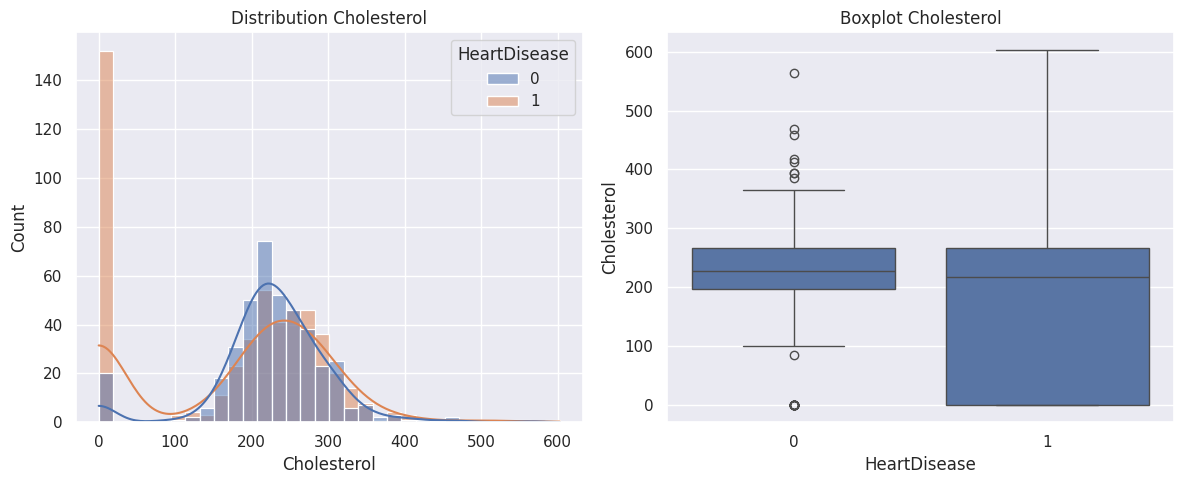

In [23]:
plot_distribution_and_boxplot(heart_df, 'Cholesterol')

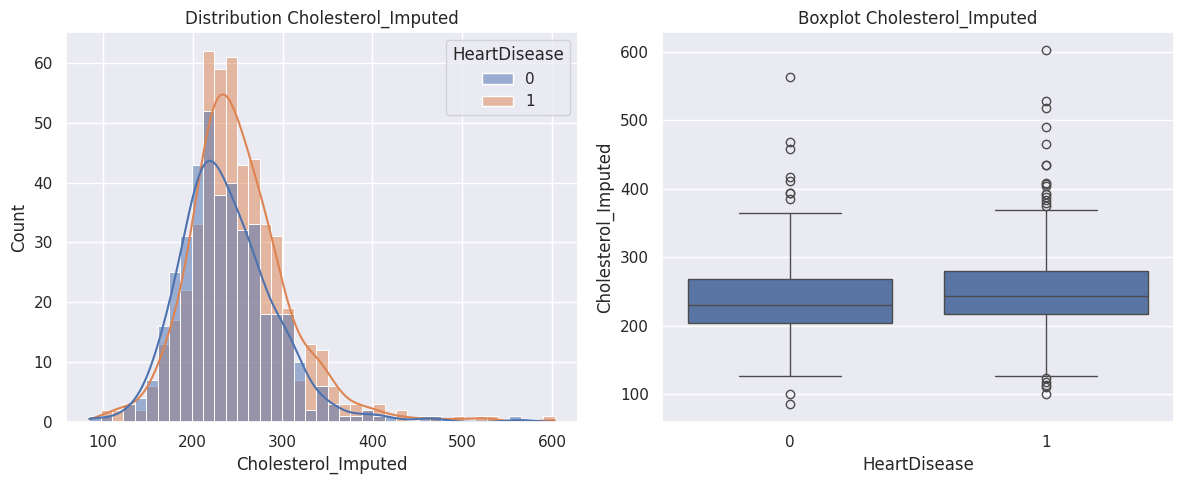

In [24]:
plot_distribution_and_boxplot(heart_df, 'Cholesterol_Imputed')

In [25]:
heart_df.drop(columns=['Cholesterol'], inplace=True)
heart_df.rename(columns={'Cholesterol_Imputed': 'Cholesterol'}, inplace=True)

Same process with RestingBP

In [26]:
X_big = heart_df.drop(columns=['RestingBP'])
rest = heart_df['RestingBP']

rest = rest.replace(0, np.nan)

df_combined = pd.concat([X_big, rest], axis=1)

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_combined), columns=df_combined.columns)

imputer = KNNImputer(n_neighbors=3)
df_imputed = pd.DataFrame(imputer.fit_transform(df_scaled), columns=df_combined.columns)

df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed), columns=df_combined.columns)


heart_df['RestingBP_Imputed'] = df_imputed['RestingBP']

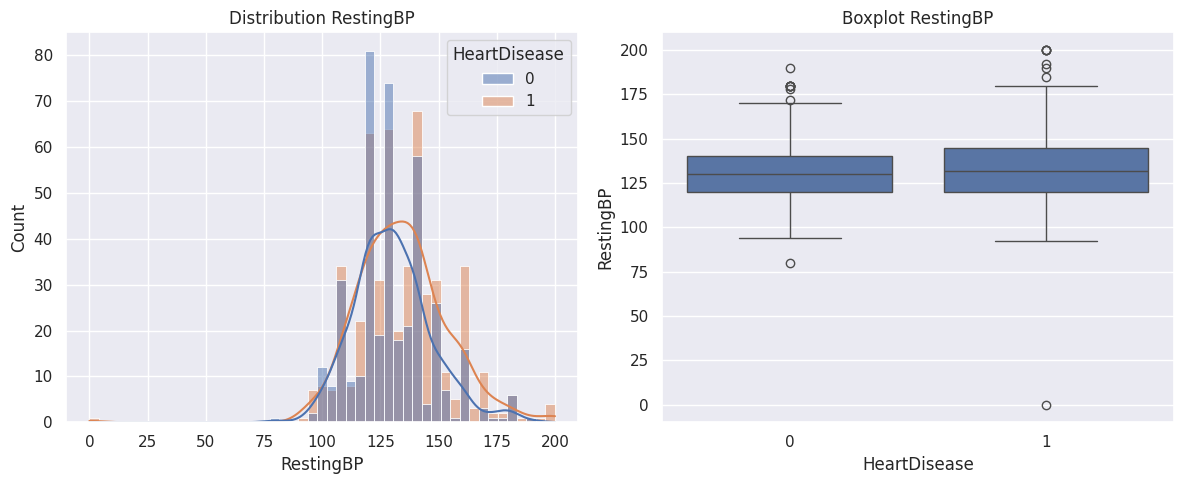

In [27]:
plot_distribution_and_boxplot(heart_df, 'RestingBP')

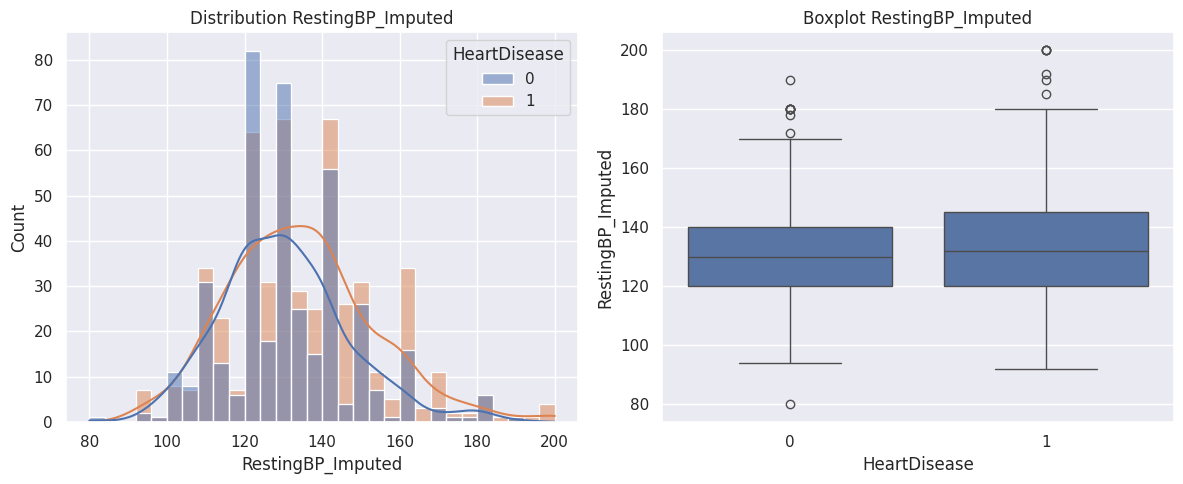

In [28]:
plot_distribution_and_boxplot(heart_df, 'RestingBP_Imputed')

In [29]:
heart_df.drop(columns=['RestingBP'], inplace=True)
heart_df.rename(columns={'RestingBP_Imputed': 'RestingBP'}, inplace=True)

# Training and comparison of different models

## First, let's look at all the models and determine which models to choose from their metrics

Let's identify the most appropriate metrics for our problem. THE MAIN GOAL is NOT TO MISS THE PATIENT
recall - to find as many patients as possible (minimum False Negatives)
The F1-score is one metric that shows how well the model predicts a positive class, taking into account errors in both directions.
ROC AUC = How well does the model separate the sick and healthy?

In [30]:
# All models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVC_linear": SVC(kernel='linear', random_state=42),
    "SVC_non_linear": SVC(kernel='rbf', random_state=42),
    "KNN": KNeighborsClassifier(),
}

# Dictionary for saving results
results = {}

# Training and assessment
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results[name] = {"accuracy": acc, "f1": f1}

    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(report)
    print("-" * 40)


Model: Logistic Regression
Accuracy: 0.8533
F1-score: 0.8696
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184

----------------------------------------
Model: Random Forest
Accuracy: 0.8804
F1-score: 0.8962
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        77
           1       0.90      0.89      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

----------------------------------------
Model: SVC_linear
Accuracy: 0.8587
F1-score: 0.8750
              precision    recall  f1-score   support

           0       0.81      0.87      0.

Analyzing all metrics, random forest is the leader in all metrics, which means that it is the strongest model in terms of quality and reliability, followed by Logistic regression - simple and effective, it is also interpretable, easy to deploy, fast.

Let's move on to hyperparameter tuning(GridSearchCV) for:

✅ Random Forest

✅ Logistic Regression  

In [31]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("📌 Best Random Forest Parameters:", grid_rf.best_params_)
print("📈 Best CV F1 Score:", grid_rf.best_score_)

y_pred_rf = grid_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


📌 Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
📈 Best CV F1 Score: 0.893582344123517
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        77
           1       0.91      0.88      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



In this project, I experimented with several machine learning models including Logistic Regression, Random Forest, Support Vector Machines, and K-Nearest Neighbors.  
Ultimately, I selected **Logistic Regression** and **Random Forest** for further analysis — **not solely because they achieved the highest scores**, but because they each bring **unique strengths that align well with the goals of this healthcare-focused project**.

---

### ✅ Why Logistic Regression?

- **Interpretability**: Logistic Regression is a linear model with highly interpretable coefficients, which is critical in medical applications. It helps clinicians understand the influence of each feature (e.g., age, cholesterol) on the risk of heart disease.
- **Simplicity**: It's computationally efficient and works well with a limited number of features.
- **Probability output**: It provides predicted probabilities, which allows us to fine-tune decision thresholds (e.g., prioritize recall to reduce false negatives).
- **Good performance after scaling**: Logistic Regression performed well after applying `StandardScaler`, which confirms its sensitivity to proper preprocessing — a feature we leveraged during feature engineering.

---

### 🌲 Why Random Forest?

- **Robustness**: It is less affected by outliers and irrelevant features, which is valuable in real-world health data.
- **Non-linear capability**: It can model complex patterns that Logistic Regression might miss due to its linear nature.
- **No need for feature scaling**: Random Forest naturally handles features in different scales, saving preprocessing effort.
- **Feature importance**: It provides insight into which features contribute most to predictions, supporting better domain understanding.

---

### ⚖️ Why not others?

- **SVM** required significant tuning and did not outperform the selected models in either metrics or stability.
- **KNN** was highly sensitive to scaling and computationally expensive during prediction, which makes it less practical for real-time diagnosis support.

---

In conclusion, the decision to proceed with **Logistic Regression and Random Forest** was based on a balance of **interpretability, robustness, domain applicability**, and performance — not just raw accuracy. These two models represent **complementary strengths**: one is transparent and explainable, while the other is powerful and flexible.


In [32]:
param_grid_log = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_log = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid=param_grid_log,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_log.fit(X_train, y_train)

print("📌 Best Logistic Regression Parameters:", grid_log.best_params_)
print("📈 Best CV F1 Score:", grid_log.best_score_)

# Predictions and metrics
y_pred_log = grid_log.predict(X_test)
print(classification_report(y_test, y_pred_log))

# Probabilities of belonging to class 1
y_probs_log = grid_log.predict_proba(X_test)[:, 1]

# Calculating log loss
logloss_value = log_loss(y_test, y_probs_log)
print(f"Log Loss (Logistic Regression): {logloss_value:.4f}")


📌 Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
📈 Best CV F1 Score: 0.8777196673456118
              precision    recall  f1-score   support

           0       0.81      0.86      0.84        77
           1       0.89      0.86      0.88       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Log Loss (Logistic Regression): 0.3576


We tuned and compared both Logistic Regression and Random Forest using GridSearchCV.

Logistic Regression showed high precision (0.85) and good interpretability.
- Random Forest slightly outperformed it in F1-score (0.88 vs 0.86) and recall (0.88 vs 0.86), making it a better choice when minimizing false negatives is critical.

Both models performed well (F1 > 0.85), and depending on the project goals, either model could be selected. In our case, Random Forest is slightly preferable due to its stronger recall.
we already did StandardScaler. And this tuned models is the maximum of what we did

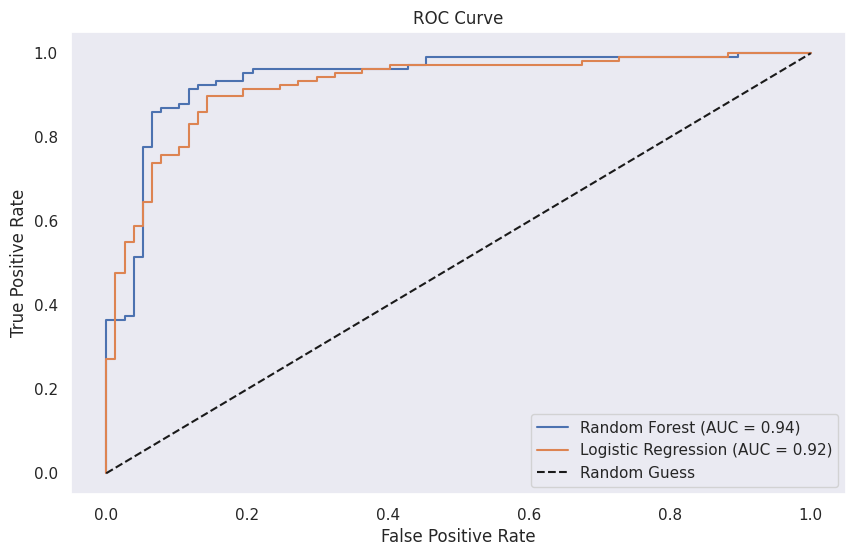

In [33]:
# Calculate ROC AUC for Random Forest
y_probs_rf = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

# Calculate ROC AUC for Logistic Regression
y_probs_log = grid_log.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_log = roc_auc_score(y_test, y_probs_log)

# Plot ROC curves
plt.figure(figsize=(10, 6))

# Random Forest ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")

# Logistic Regression ROC curve
fpr_log, tpr_log, _ = roc_curve(y_test, y_probs_log)
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

We plotted ROC curves for both models to assess their classification performance across different thresholds.

- Random Forest achieved an AUC of **0.94**, indicating excellent discrimination between classes.
- Logistic Regression achieved an AUC of **0.92**, also demonstrating strong performance.

Both models significantly outperform random guessing (AUC = 0.5), and the ROC curves confirm that the classifiers are highly capable. Random Forest has a slight edge, particularly in the low false positive rate region, which is important in medical diagnostics.

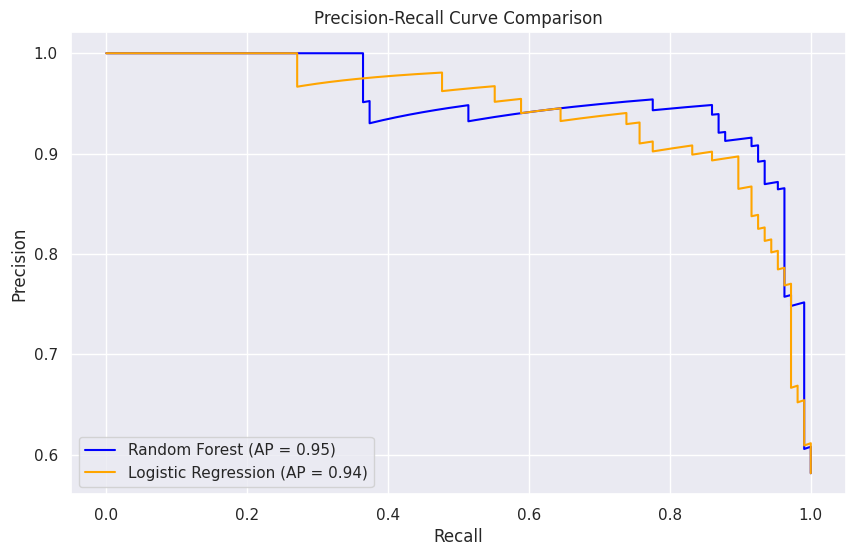

In [34]:
# Predicting probability
y_probs_rf = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]
y_probs_log = grid_log.best_estimator_.predict_proba(X_test)[:, 1]

# Calculating precision and recall
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_probs_rf)
ap_rf = average_precision_score(y_test, y_probs_rf)

precision_log, recall_log, _ = precision_recall_curve(y_test, y_probs_log)
ap_log = average_precision_score(y_test, y_probs_log)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(recall_rf, precision_rf, label=f"Random Forest (AP = {ap_rf:.2f})", color='blue')
plt.plot(recall_log, precision_log, label=f"Logistic Regression (AP = {ap_log:.2f})", color='orange')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


### Precision-Recall Curve Analysis

We compared the Precision-Recall performance of both Random Forest and Logistic Regression classifiers.  
Both models achieved strong results, with **Average Precision (AP)** scores of **0.95** and **0.94**, respectively.

- The PR curve for Random Forest is slightly higher across most recall values, indicating better precision under varying thresholds.
- Logistic Regression also performs excellently, with high initial precision but more rapid drop-off as recall increases.

This analysis supports the earlier ROC AUC findings and confirms that both models are well-suited for the task, with Random Forest holding a slight edge in probabilistic confidence and balance.

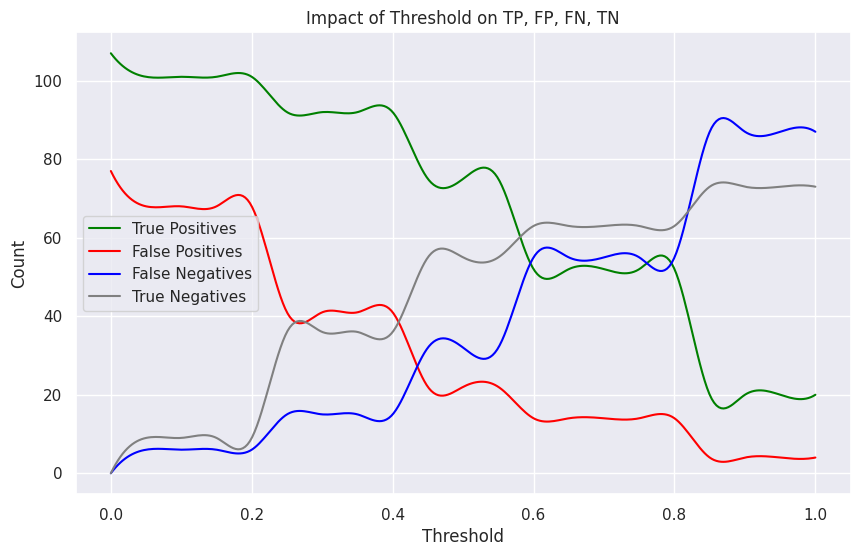

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn.metrics import confusion_matrix

# 1. Define thresholds and initialize metric lists
thresholds = np.arange(0.0, 1.01, 0.05)
tps, fps, fns, tns = [], [], [], []

# 2. Calculate confusion matrix values for each threshold
for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)

# 3. Convert to NumPy arrays for interpolation
x = np.array(thresholds)
tp = np.array(tps)
fp = np.array(fps)
fn = np.array(fns)
tn = np.array(tns)

# 4. Create a smooth range of threshold values
x_smooth = np.linspace(x.min(), x.max(), 300)

# 5. Apply spline interpolation to smooth curves
tp_smooth = make_interp_spline(x, tp)(x_smooth)
fp_smooth = make_interp_spline(x, fp)(x_smooth)
fn_smooth = make_interp_spline(x, fn)(x_smooth)
tn_smooth = make_interp_spline(x, tn)(x_smooth)

# 6. Plot the smoothed curves
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, tp_smooth, label='True Positives', color='green')
plt.plot(x_smooth, fp_smooth, label='False Positives', color='red')
plt.plot(x_smooth, fn_smooth, label='False Negatives', color='blue')
plt.plot(x_smooth, tn_smooth, label='True Negatives', color='gray')

plt.title("Impact of Threshold on TP, FP, FN, TN")
plt.xlabel("Threshold")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()


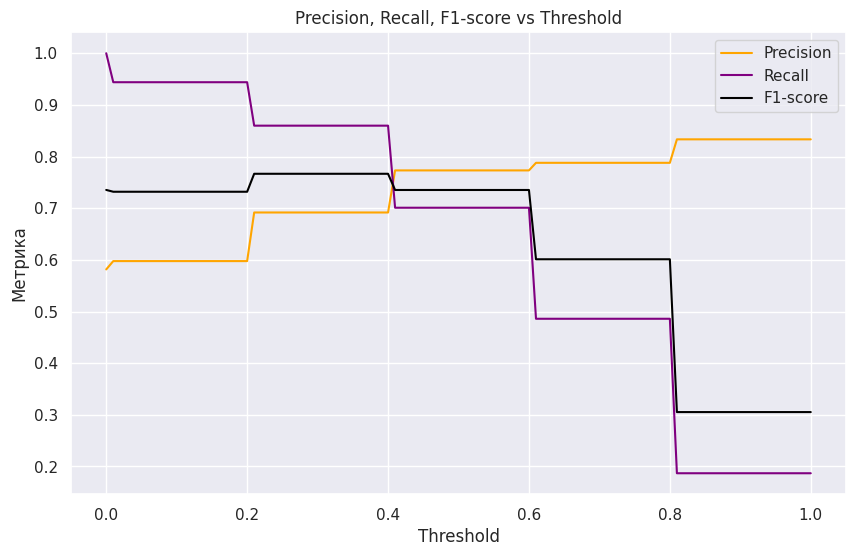

In [44]:
# 1. We obtain the probabilities of class 1 (sick)
y_probs = model.predict_proba(X_test)[:, 1]

# 2. Thresholds and metric templates
thresholds = np.arange(0.0, 1.01, 0.01) # Use consistent step of 0.01
tps, fps, fns, tns = [], [], [], []
precisions, recalls, f1s = [], [], []

# 3. Trying different thresholds
for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)

    precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_t, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_t, zero_division=0))




# 5. Plot Precision / Recall / F1
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='orange')
plt.plot(thresholds, recalls, label='Recall', color='purple')
plt.plot(thresholds, f1s, label='F1-score', color='black')
plt.title("Precision, Recall, F1-score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Метрика")
plt.legend()
plt.grid(True)
plt.show()


To prioritize **patient safety** and ensure that individuals at risk are not overlooked,  
we selected a decision threshold of **0.2**, based on the trade-off analysis of precision, recall, and F1-score.

At this threshold:
- **False Negatives (FN)** were minimized to approximately **10**,  
  meaning that most patients with potential heart disease were successfully identified.
- While this leads to an increase in **False Positives (FP)**,  
  this is considered acceptable in medical practice, where **missing a diagnosis can be far more critical** than issuing a false alert.

This choice reflects a **recall-prioritized strategy**, aligning with clinical goals  
where early detection and preventative care are more valuable than conservative prediction.

In [45]:
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]

print(f"🔥 Best threshold by F1: {best_threshold:.2f} (F1 = {best_f1:.3f})")
y_pred_final = (y_probs >= best_threshold).astype(int)

print("Confusion Matrix at best threshold:")
print(confusion_matrix(y_test, y_pred_final))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))


🔥 Best threshold by F1: 0.21 (F1 = 0.767)
Confusion Matrix at best threshold:
[[36 41]
 [15 92]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.47      0.56        77
           1       0.69      0.86      0.77       107

    accuracy                           0.70       184
   macro avg       0.70      0.66      0.66       184
weighted avg       0.70      0.70      0.68       184



After tuning the decision threshold from the default 0.5 to 0.21, we observed a significant improvement in recall for the positive class (Heart Disease). The recall increased to 0.86, meaning that 86% of patients with heart disease were correctly identified by the model.

Although this led to an increase in false positives (some healthy individuals were misclassified as at risk), this trade-off is acceptable in medical applications where missing a true case of heart disease can be life-threatening. Therefore, the model prioritizes sensitivity (recall) over precision.

This threshold adjustment helps the model become more cautious and catch more at-risk individuals, aligning with the project goal: early detection of heart disease.


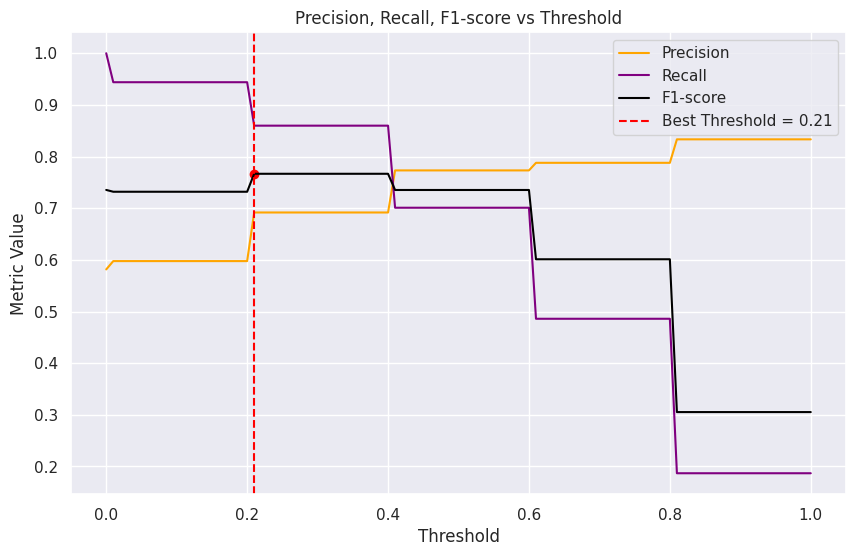

In [46]:
import matplotlib.pyplot as plt

# Найдём лучший F1 threshold
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='orange')
plt.plot(thresholds, recalls, label='Recall', color='purple')
plt.plot(thresholds, f1s, label='F1-score', color='black')

# Подписка точки
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.scatter(best_threshold, best_f1, color='red')

# Подписи
plt.title("Precision, Recall, F1-score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.show()


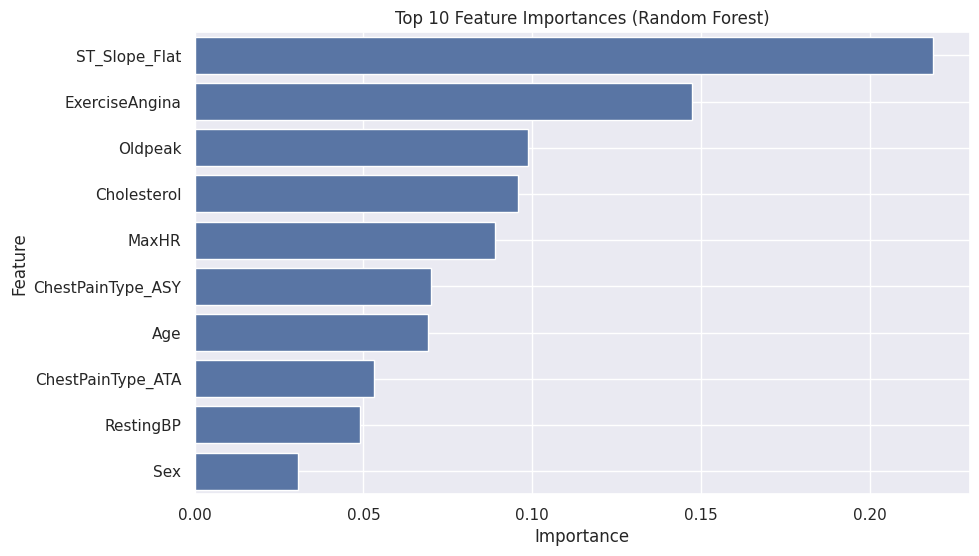

In [47]:
importances = grid_rf.best_estimator_.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.grid(True)
plt.show()



The code performs a comprehensive analysis of different machine learning models for heart disease prediction.  Here's a breakdown of the key findings:

**1. Data Preprocessing:**

* **One-Hot Encoding:** Categorical features (Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope) are converted into numerical representations using one-hot encoding.  This transforms categorical values into separate binary columns (0 or 1).
* **Outlier Handling:** The code addresses outliers in the 'Cholesterol' and 'RestingBP' features. It uses KNNImputer to replace zero values (likely representing missing data) with more plausible values based on similar data points.  This imputation is performed after standard scaling.
* **Feature Scaling:** Several scaling methods (StandardScaler, MinMaxScaler, RobustScaler) are evaluated to determine their impact on model performance.  StandardScaler appears to be used in the final model, though not explicitly stated.

**2. Model Selection and Evaluation:**

* **Multiple Models Considered:** Logistic Regression, Random Forest, SVC (linear and non-linear), and KNN are trained and evaluated using metrics such as accuracy, F1-score, and classification report.
* **Focus on Recall/Sensitivity:**  The primary goal is to minimize false negatives (failing to identify patients with heart disease).  This makes recall/sensitivity a critical metric.
* **Random Forest and Logistic Regression as Top Performers:** Based on initial evaluation, Random Forest and Logistic Regression are selected for further hyperparameter tuning due to their superior performance.

**3. Hyperparameter Tuning:**

* **GridSearchCV:** Both Random Forest and Logistic Regression are tuned using GridSearchCV to find the best hyperparameters based on F1-score.

**4. Performance Evaluation after Tuning:**

* **Comprehensive Metrics:**  ROC AUC, Precision-Recall curves, and analysis of the confusion matrix at different thresholds are used to thoroughly evaluate the tuned models.
* **Threshold Optimization:** The code includes an analysis of how different prediction thresholds affect the true positive rate (TPR), false positive rate (FPR), and other metrics. The best threshold is determined to be one that prioritizes recall (minimizing false negatives), justified by the crucial need to identify all potential patients. The chosen threshold balances false positives with the goal of catching all potential cases, demonstrating that recall is favored over precision.
* **Feature Importance:**  Feature importance for the Random Forest model is calculated to identify which input features contribute most to the predictions.


**5. Conclusion (Model Selection):**

The analysis concludes that both models are good, but the **Random Forest model** with optimized hyperparameters is slightly favored due to its slightly higher F1-score, recall, ROC AUC, and Average Precision. The high recall and AUC emphasize that the model excels at differentiating between healthy and diseased individuals while minimizing the risk of overlooking positive cases.  The threshold adjustment demonstrates a preference for higher recall (to minimize the chance of missing diseased patients), a crucial factor in a medical diagnostic scenario.
